<h1>[GD_06]직접 만들어보는 OCR<h1>

- Text recognition을 위해 특화된 데이터셋 구성이 체계적으로 진행되었다.<br>
(텍스트 이미지 리사이징, ctc loss측정을 위한 라벨 인코딩, 배치 처리 등이 적절히 수행되었다.)<br>
- CRNN기반의 recognition모델의 학습이 정상적으로 진행되었다.<br>
(학습결과 loss가 안정적으로 감소하고 대부분의 문자인식 추론 결과가 정확하다.)<br>
- keras-ocr detector와 CRNN recognizer를 엮어 원본 이미지 입력으로부터 text가 출력되는 OCR이 End-to-End로 구성되었다.<br>
(샘플 이미지를 원본으로 받아 OCR 수행 결과를 리턴하는 1개의 함수가 만들어졌다.)<bt>

<h2>Recognition model</h2>

숫자와 알파벳(대문자)를 정의합니다

In [1]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


<h2>Import Libraries<h2>

In [2]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

<h2>Load Data<h2>

In [3]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [4]:
BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


<h2>Recognition model(2) Input Image</h2>

<h3>lmdb 불러오기</h3>

In [5]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

<h3>lmdb데이터셋의 이미지를 열어 실제 shape와 label 정보 확인하기</h3>

lmdb 데이터베이스는 키-값 쌍의 형태로 데이터를 저장하는데, 여기서 키는 고유한 문자열이며, 값은 이 문자열에 연관된 데이터입니다. 이러한 특징은 텍스트 인식 분야에서 매우 유용합니다. 예를 들어, 이미지와 해당 이미지에 포함된 텍스트(GT)을 저장하는데에 Imdb를 사용할 수 있습니다. 실제로 대부분의 텍스트 인식 모델의 공식 코드에서 Imdb형식의 데이터셋을 사용하고 있습니다.<br>
<br>
<h4>Imdb데이터베이스에 데이터 쓰기</h4>
- env.begin 함수를 사용하여 트랜잭션을 시작하고, txn.put함수를 사용하여 데이터를 쓸 수 있음<br>
- put함수의 첫번째 인자로는 데이터의 key를, 두번째 인자로는 데이터의 value를 전달<br>
- 데이터베이스에 저장할 때는 문자열이 아닌 bytes형식으로 저장해야 하므로, encode함수를 사용하여 문자열을 bytes로 변환<br>

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


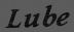

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


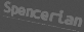

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


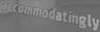

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


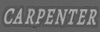

In [6]:
# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

original image의 가로가 다르니 일정한 길이로 변환이 필요합니다.

<h3>lmdb를 활용한 MJSynth 데이터셋 클래스 구현</h3>

In [7]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

이 코드는 LMDB 데이터베이스에서 이미지와 라벨을 읽어와서 출력하는 예시일 뿐, 실제로는 이미지 분류나 학습 데이터 준비와 관련된 작업을 수행하기 위한 부분이 더 있을 것입니다. 코드에서 사용된 라이브러리로 보아, 이미지 데이터셋을 다루는 일반적인 작업일 수 있습니다.

<h2>Encode</h2>

Label을 살펴보면 우리가 읽을 수 있는 평문 Text로 이루어져 있었습니다. 하지만 이것은 모델을 학습하기 위해서 적절한 형태가 아닙니다. 따라서 각 Character를 class로 생각하고 이를 step에 따른 class index로 변환해서 encode를 해주어야 합니다.

- __init__()에서는 입력을 받은 text를 self.dict에 각 character들이 어떤 index에 매핑되는지 저장합니다. 이 character와 index 정보를 통해 모델이 학습할 수 있는 output이 만들어집니다. 만약 character='ABCD'라면 'A'의 label은 1,'B'의 label은 2가 됩니다.
- 공백(blank)문자를 지정합니다. 여기서는 공백 문자를 뜻하기 위해 '-'를 활용하며, label은 0으로 지정합니다.
- decode()는 각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 바꾸어줍니다.

In [8]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

아래에서 'HELLO'를 Encode한 후 Decode가 정상적으로 되는지 확인해보도록 해보세요!

In [9]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


동일한 글자 'L'이 연속될 때, 그 사이에 공백 문자가 포함된 것을 확인할 수 있습니다.

<h2>Build CRNN model</h2>

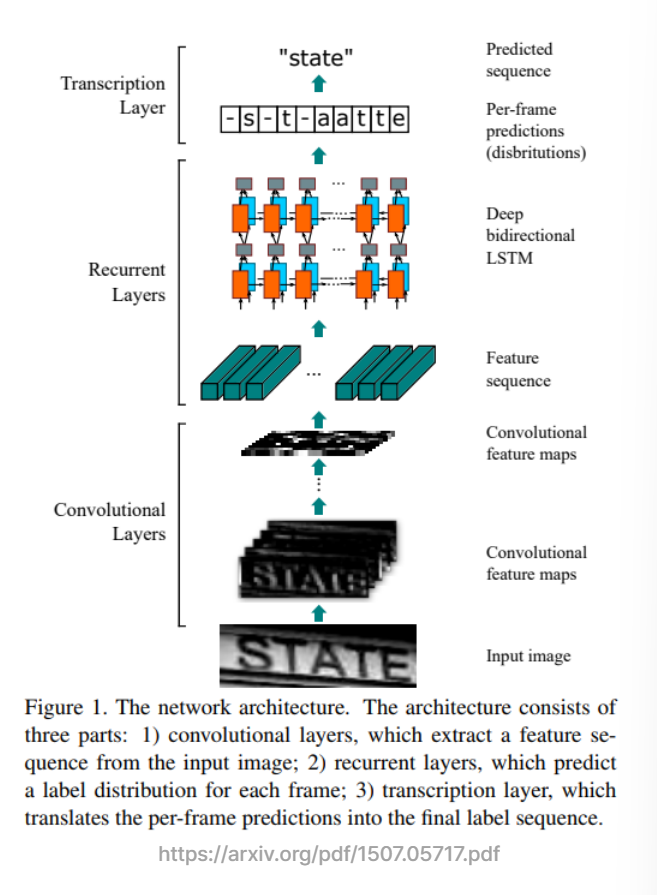

CRNN은 CNN과 RNN을 섞은 모델로 이미지를 입력으로 받아 특징을 추출하고, 추출한 특징을 바탕으로 RNN을 통해 시퀀스별 글자를 예측하는 모델을 말한다.<br>
<br>
CRNN 구조는 위 이미지와 같다.
Convolution Layers + Recurrent Layers + Transcription Layers
총 3가지 Layer로 구성되어 있는데, 다음은 각 Layer의 특징이다.
- Convolution Layers : 입력 이미지로부터 feature 시퀀스 추출(->CNNs)
- Recurrent Layers : 각 프레임마다 라벨 예측(->RNNs)
- Transcriptional Layers : 프레임마다의 예측을 최종 라벨 시퀀스로 변경

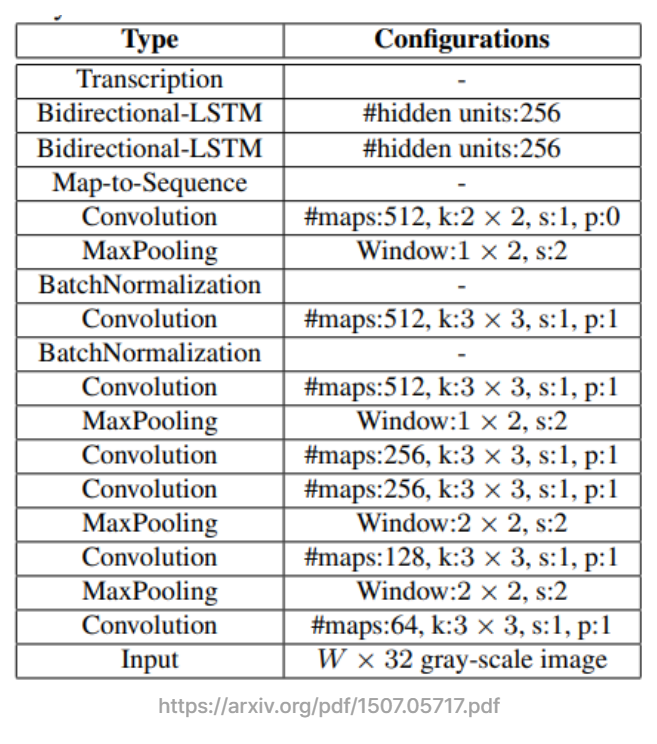

이제 입력과 출력을 준비했으니 모델을 만들어볼 차례입니다. Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산하도록 ctc_lambda_func를 아래와 같이 만들어두었습니다.

In [10]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

<h3>CTC Loss 함수</h3>

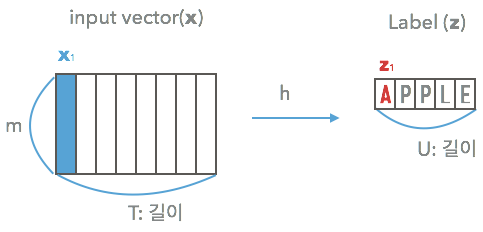

CTC의 사용이유
- text-line의 이미지가 있는 데이터셋을 생성
- 각 이미지의 수평 위치에 대해 일치하는 문자를 지정
- 각각의 수평적인 위치에 문자 점수를 출력하도록 뉴럴 네트워크를 학습

학습 데이터에 클래스 라벨만 순서대로 있고 각 클래스의 위치가 어디있는지 모르는 unsegmented 시퀀스 데이터의 학습을 위해서 사용하는 알고리즘입니다.

CTC의 내용
- 발화에는 띄어쓰기, 묵음 등이 존재할 수 있다.
- \epsilon이라는 토큰을 추가한다.
- CTC는 input과 같은 길이의 alignment를 만들고 y를 mapping하면서 \epsilon을 제거하면 해당 output과 길이가 같은 결과를 얻을 수 있다.

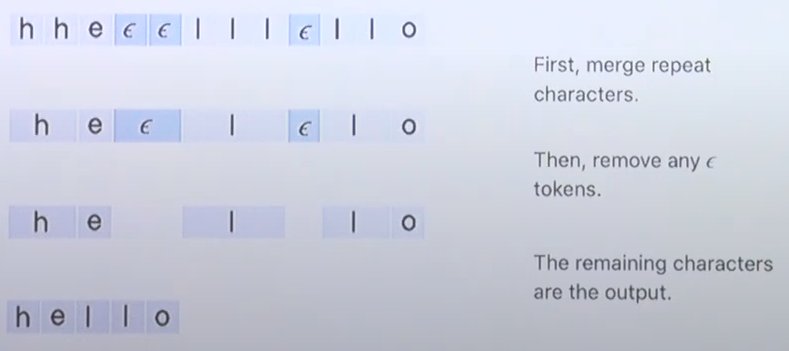

- 'hello'만 하더라도 다양한 발화 방법이 존재한다.
- 따라서 가능한 모든 ailgnment를 고려한 모델을 만드는 것이 CTC의 방법이다.
- 하나의 input에서 next input으로 진행하면서 output을 동일하게 유지하거나 next output으로 assign한다(즉, 순서가 중요하다)

In [11]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

<h2>Train & Inference</h2>

In [12]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=False, save_weights_only=True, period=5
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
history = model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=30,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/30
565/565 [==============================] - 93s 143ms/step - loss: 25.3347 - val_loss: 22.6722
Epoch 2/30
565/565 [==============================] - 81s 143ms/step - loss: 14.0313 - val_loss: 9.6662
Epoch 3/30
565/565 [==============================] - 80s 142ms/step - loss: 6.9532 - val_loss: 6.3426
Epoch 4/30
565/565 [==============================] - 80s 142ms/step - loss: 5.0624 - val_loss: 5.4227
Epoch 5/30
565/565 [==============================] - 80s 142ms/step - loss: 4.0330 - val_loss: 4.7624

Epoch 00005: saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5
Epoch 6/30
565/565 [==============================] - 81s 142ms/step - loss: 3.3119 - val_loss: 4.2584
Epoch 7/30
565/565 [==============================] - 80s 142ms/step - loss: 2.7311 - val_loss: 4.3583
Epoch 8/30
565/565 [==============================] - 80s 142ms/step - loss: 2.2577 - val_loss: 4.1848
Epoch 9/30
565/565 [==============================] - 80s 142ms/step - loss: 1.8452 - val_loss: 4.2590

epoch=20을 했을 때에 학습 결과가 너무 좋지 않아 epoch=30으로 하여 다시 돌려보았다. 돌려보았는데 18epoch까지 밖에 안 돌아간다...

In [14]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


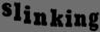

Result: 	 ALEPPO


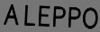

Result: 	 FWANDA


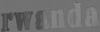

Result: 	 NATHANS


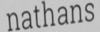

Result: 	 HALLE


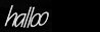

Result: 	 HURLS


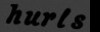

Result: 	 DOWNSIZE


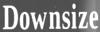

Result: 	 ROBOTIC


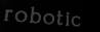

Result: 	 SLOPPY


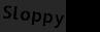

Result: 	 SHERMITE


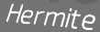

In [17]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False, beam_width=5, top_paths=1
        )[0][0]
    )[0]

    text = ""
    for index in indexes:
        # '9'를 제거하고 인덱스가 chars 리스트 범위 내에 있는지 확인
        if 0 <= index < len(chars) and chars[index] != '9':
            text += chars[index]

    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

초반에 빈 공간으로 '9'가 많이 등장하여 새로 코드를 추가하여 '9'를 모두 삭제하고 글자만 나올 수 있도록 처리하였습니다.

<h2>learning curve</h2>

dict_keys(['loss', 'val_loss'])


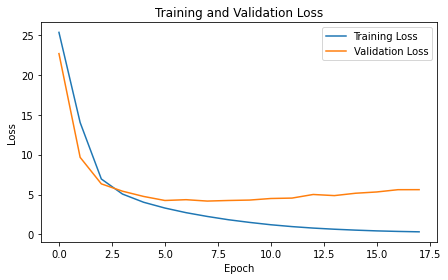

In [18]:
import matplotlib.pyplot as plt

# Assuming 'history' is defined after calling model.fit()

# Check the keys in the history object
print(history.history.keys())

# Adjust the keys for accuracy and loss based on the printed output
accuracy_key = 'acc' if 'acc' in history.history else 'accuracy'

# Retrieve training history
acc = history.history.get(accuracy_key, [])  # Use get() to handle KeyError
val_acc = history.history.get('val_' + accuracy_key, [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])

# Continue with the plotting code
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


<h2>Sample.jpg 분석 실험</h2>

In [20]:
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [21]:
def detect_text(img_path):
    # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    # 배치의 첫 번째 결과만 가져옵니다.
    # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    det_result = detector.detect(img.numpy())
        # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = det_result[0]
        # 시각화를 위해서 x와 y좌표를 변경해줍니다. (앞선 h dimension으로 인해 y,x로 표기됨)
    
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

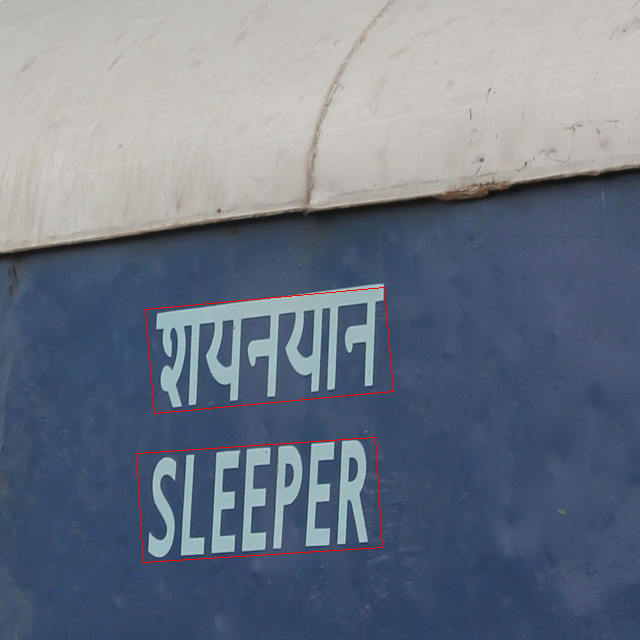

In [22]:
from PIL import Image, ImageDraw
from IPython.display import display
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

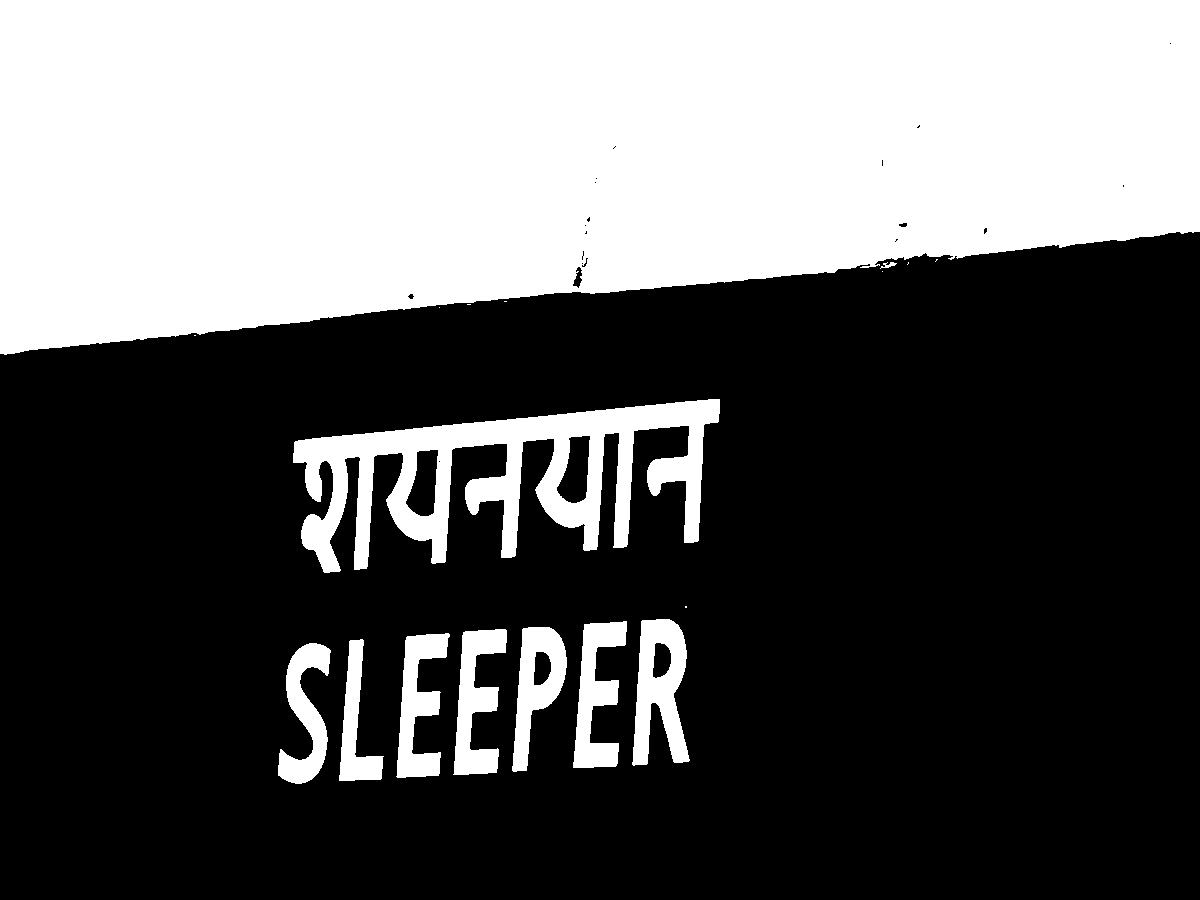

중간에 전처리된 이미지를 보면 흑백으로 잘 나누어진 것을 확인할 수 있습니다.

In [23]:
def recognize_img(input_img, input_img_size=(100,32)):
    # 잘려진 단어 이미지를 인식하는 코드
    pil_img = input_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 STRUPRUIE


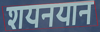

Result: 	 SLEEPERE


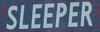

In [24]:
for _img in cropped_img:
    recognize_img(_img)

<h2>pytesseract 써보기(미션3)</h2>

In [25]:
import pytesseract
from pytesseract import Output

In [32]:
from PIL import Image

img = Image.open(path + '/data/sample.jpg')
result = pytesseract.image_to_string(img,lang = 'eng')
print(result)

 

qavat
ad



<h3>전처리를 추가하여 시도</h3>

In [36]:
from PIL import Image
import pytesseract
import cv2

# 이미지 열기
img = Image.open(path + '/data/sample.jpg')

# 이미지를 OpenCV 형식으로 변환
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# 이미지 이진화
gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

# 이미지 저장 (옵션)
cv2.imwrite('binary_image.png', binary)

# 언어 지정하여 텍스트 추출
text = pytesseract.image_to_string(Image.fromarray(binary), lang='eng')

print(text)

 

be
aad



lang을 'eng'으로 설정하여 진행하였지만 여전히 인식에 어려움을 느끼는 것 같다. 그래서 이번에는 한글 간판을 한번 인식시켜보기로 하였습니다.

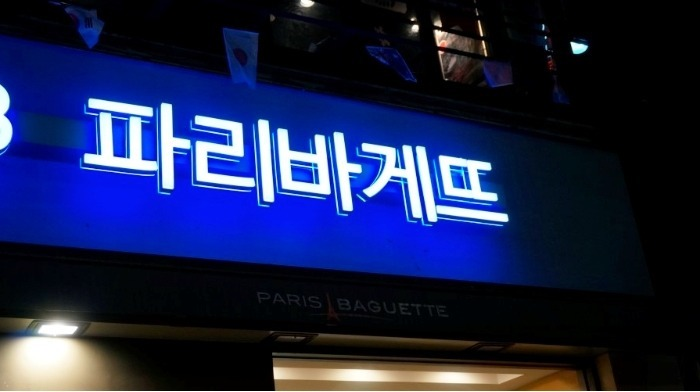

In [38]:
from PIL import Image

img = Image.open(path + '/korean_text.jpg')
result = pytesseract.image_to_string(img,lang = 'kor')
print(result)

고!  개

베비 기이 이(여
_ ㄱㄴㅠㄴ ~



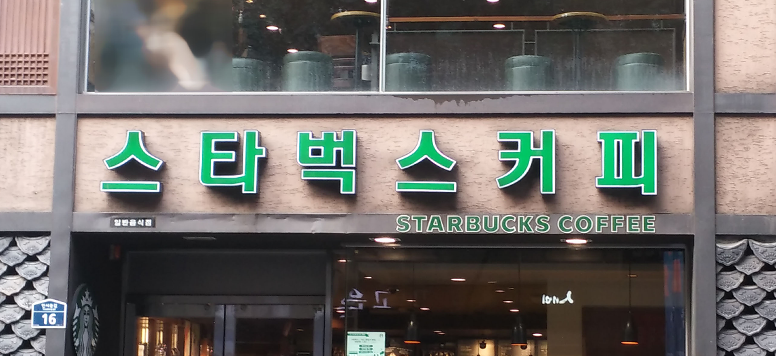

In [40]:
from PIL import Image

img = Image.open(path + '/star.png')
result = pytesseract.image_to_string(img,lang = 'kor')
print(result)

lang을 'kor'로 설정하여 진행해보았지만 역시나 인식을 못하는 모습을 볼 수 있습니다. 특히 상단의 사진의 경우 저녁에 촬영되어 글자가 더 잘보이는 입장이라 무언가 결과물이 나오기는 하는데 아래 아침에 촬영된 사진의 경우 정확하게 segmentation을 진행을 못하는 모습을 볼 수 있습니다. 

<h2>회고</h2>

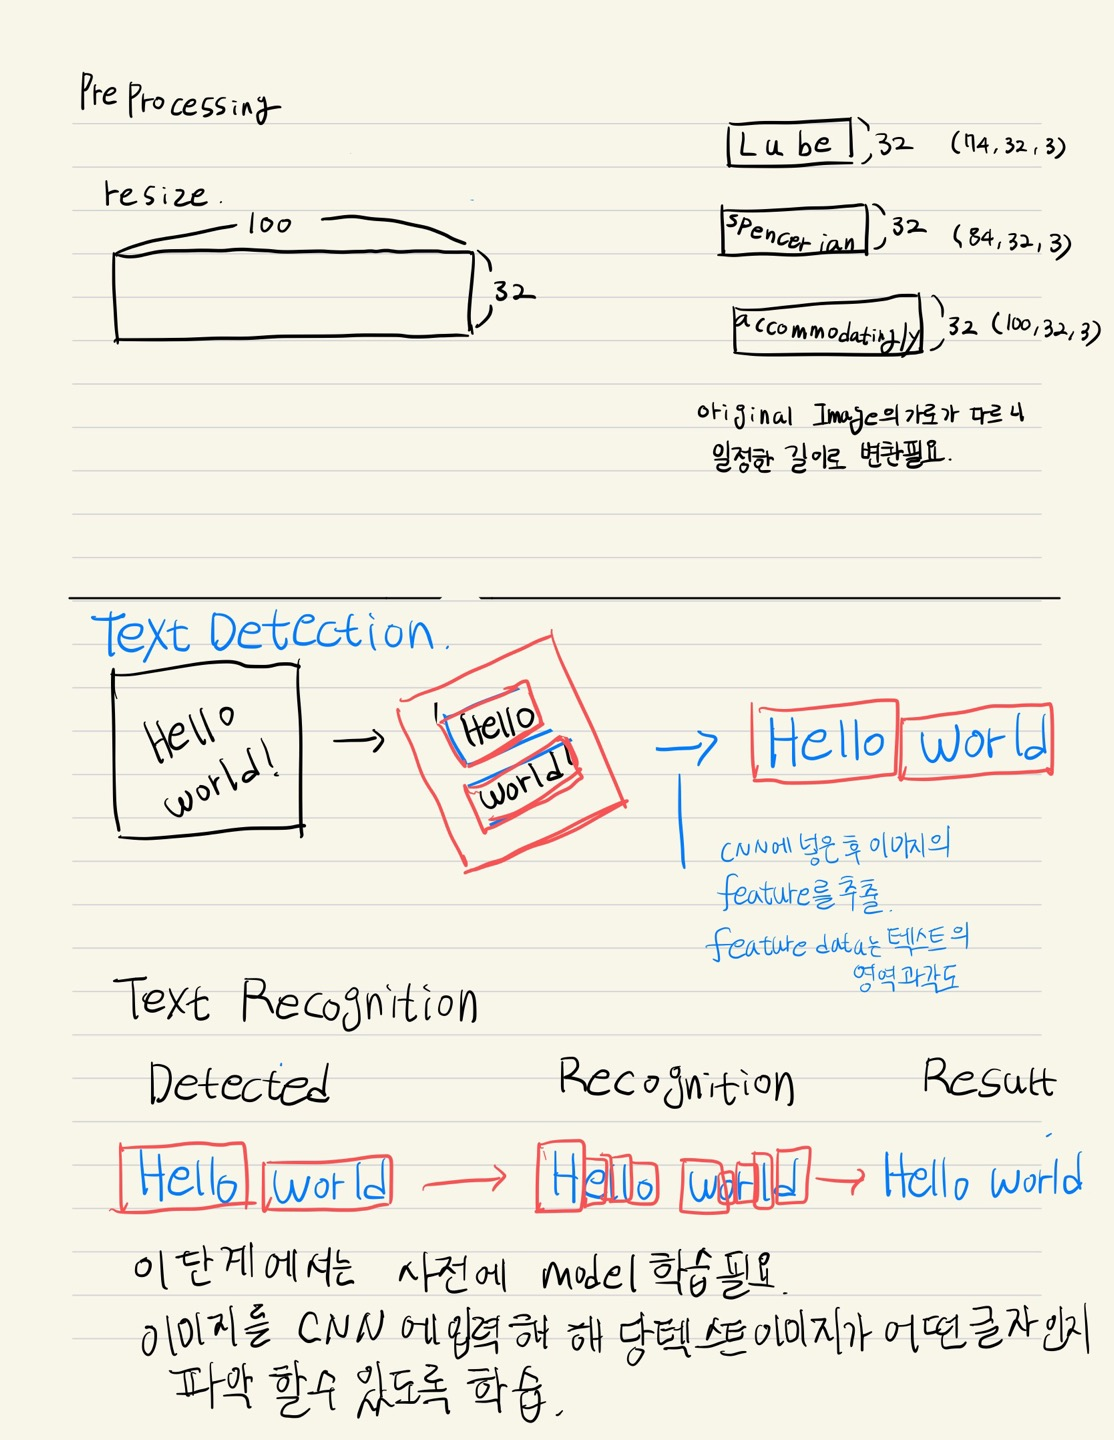

직접 anchor box를 그려보면서 공부가 많이 되었던 것 같습니다. 크게 역할을 나누어 보면 TextDetection/Text Recognition을 진행하는 것을 볼 수 있습니다. 그리고 앵커 박스는 다양한 종횡비와 비율을 가질 수 있어 다양한 형태와 크기의 객체를 처리할 수 있어 편리하다고 볼 수 있습니다. 

처음으로 CTC를 접하게 되었는데 헷갈리는 점들이 많아 여기 회고에서 조금 정리를 하고자합니다^^; 텍스트의 경우 이미지 처럼 일정한 가로 길이를 가지기는 어렵고 다양하게 변할 수 있습니다. CTC는 입력 이미지와 해당 이미지에서 추출한 텍스트 시퀀스 간의 길이 차이를 고려하여 정렬 문제를 해결할 수 있습니다. 또한 고려해야할 점은 글자간의 간격이나 폰트 및 스타일입니다. CTC의 경우 글자 간 간격이나 정렬과 폰트 및 스타일에 대한 정보가 학습과정에서 모델에 내장되어있어 인식할 수 있다고 합니다.

마지막으로 pytesseract의 경우 제대로 작동이 되지 않는 모습을 볼 수 있었습니다... 인터넷으로 살펴보면 영수증에 있는 작은 글씨도 잘 분류하는 모습을 볼 수 있는데 저의 경우 크고 단순한 간판 글자인데 분류를 잘 못합니다... 영어를 분류하지 못하는 모습을 보고 한글로 바꿔서 2번 시도해보았지만 결국 문제가 해결되지는 않았습니다. (인터넷에서 찾아봐도 이유가 없어서 한번 방법을 찾아보겠습니다...)